In [1]:
import numpy as np
import pandas as pd
from scipy import signal
import matplotlib.pyplot as plt
from scipy import stats
from scipy.optimize import curve_fit
import io
import requests 
from bs4 import BeautifulSoup
import time
from matplotlib.lines import Line2D
import os
import csv
from os import listdir
from scipy import ndimage
from scipy import stats
from scipy import signal
from HPGe import *

In [3]:
marker_list = list(Line2D.markers.keys())

In [2]:
Spectra().df

,Filename,Live time/s,Real time/s,Total CPS
0,Background_16_10_23_Mon_14_50.csv,353069.86,354394.61,1.041791
1,HPGe_21.02.2022_background.csv,1204602.50,1209121.82,2.596276
2,HPGe_Background_12.12.23.csv,411527.06,413117.24,1.946662
3,HPGe_Sample3_07.12.23.csv,777953.97,780963.11,0.447947
4,IAEA_Sample_20_11_23_Mon_10_58.csv,589490.43,591717.78,0.668286
5,IAEA_sample_05.12.22 copy.csv,1191067.75,1195547.14,4.114920
6,Sample1_23_10_23_Mon_10_39.csv,586551.55,588791.75,4.144091
7,Sample2_31_10_23_14_08.csv,690516.01,693190.81,4.447199
8,Sample3_07_11_23_Tue_11_50.csv,592161.76,594479.48,2.488062
9,Sample4_13_11_23_Mon_14_06.csv,523881.40,525880.09,4.665623


In [34]:
def err_prop(data,err):
    '''Error propagation for effect of rescaling sample 3 data'''
    S_err_S = Spec(3).S_err/Spec(3).S
    err_data = err/data
    return data*Spec(3).S * np.sqrt(S_err_S**2 + err_data**2)



### Create DataFrame of all peaks csv files of different spectra
Order: background (12/12/2023), samples 1-4, IAEA385 (2022)

In [63]:
pk_path_ls = sorted(listdir('Data/Peaks_final'))[1:] #peak csv path list
#concat all modified peak dataframe
pk_path_ls = [pk_path_ls[1]] + pk_path_ls[2:] + [pk_path_ls[0]] #reorder such that: bg, sample 1-4, iaea
df = pd.concat([peak_df_new(peak_df('Data/Peaks_final/'+path)) for path in pk_path_ls],keys = range(len(pk_path_ls)))
df.loc[3,['Net_Area_Count','Peak_CPS','Peak_CPS_BR']] = df.loc[3,['Net_Area_Count','Peak_CPS','Peak_CPS_BR']].values * Spec(3).S
df.loc[3,'Net_Area_err'] = err_prop(df.loc[3,'Net_Area_Count'].values,df.loc[3,'Net_Area_err'].values)


In [24]:
iaea_df = df.loc[5]
bg_df = df.loc[0]

### Efficiency Calibration using IAEA385 Sample

In [76]:
#Cs activity is corrected for half life
iaea_385 =pd.read_csv('IAEA385_ReferenceActivity_2019.csv',delimiter = ',') 
iaea_mass = 0.05 #kg
#merge activity to iaea peak df
iaea_df = df.loc[5].merge(iaea_385,on='Nuclide')
#peak background correction
#merge peak background dataframe with iaea peak dataframe
iaea_df = iaea_df.merge(df.loc[0][['nndc_peak_energy','Peak_CPS_BR']], on = 'nndc_peak_energy', 
how = 'left', suffixes = ['','_bg']) #df.loc[0] contains background peaks
iaea_df['Peak_CPS_BR_bg'].fillna(0,inplace = True)
#corrected count per sec/BR
iaea_df['Peak_CPS_BR_corr'] = iaea_df['Peak_CPS_BR']-iaea_df['Peak_CPS_BR_bg']
iaea_df['eff'] = iaea_df['Peak_CPS_BR_corr']/(iaea_df['Abs_Activity']*iaea_mass) #efficiency
#error propagation (assume poisson noise for peak cps error)
iaea_df['eff_err']=iaea_df['eff']* np.sqrt((iaea_df['Net_Area_err']/iaea_df['Net_Area_Count'])**2+
(iaea_df['Abs_Activity_Unc']/iaea_df['Abs_Activity'])**2 + 0.05**2) #0.05**2 from percentage error of mass

df = pd.concat([df.loc[i].merge(iaea_df[['nndc_peak_energy','eff','eff_err']],on = 'nndc_peak_energy',how = 'left')
     for i in range(len(pk_path_ls))],keys = range(len(pk_path_ls)))

In [81]:
sample_mass = np.array([0.427-0.0583, 0.5733-0.0576,0.5399-0.0581,0.5585-0.0581 ])
live_time = np.array(Spec(0).live_time)
df['pseudo_A'] = df['Peak_CPS_BR']/df['eff']
df['pseudo_A_err'] = df['pseudo_A']*np.sqrt((df['Net_Area_err']/df['Net_Area_Count'])**2+(df['eff_err']/df['eff'])**2)
df

Photopeak_Energy  Centroid Nuclide  Net_Area_Count  Net_Area_err  \
0 0             242.00    242.44   Pb214           405.1          80.4   
  1             295.24    295.59   Pb214           679.2          62.6   
  2             351.93    352.43   Pb214          1079.4          56.5   
  3             609.31    609.84   Bi214           832.3          41.3   
  4             768.36    769.08   Bi214            59.4          20.9   
...                ...       ...     ...             ...           ...   
5 56           1847.42   1847.47   Bi214           483.4          36.3   
  57           2118.55   2118.59   Bi214           339.9          35.2   
  58           2204.21   2203.88   Bi214          1069.4          44.2   
  59           2447.86   2447.86   Bi214           307.6          40.0   
  60           2614.53   2614.82   Tl208          8883.1          96.9   

      Peak_CPS  FWHM  Reduced_chi2  rounded_energy    nuc  ...  T1/2(s)  \
0 0   0.000981  1.36          3.69           242.0  Pb214  ...  1623.60   
  1   0.001644  1.20          1.71           295.0  Pb214  ...  1623.60   
  2   0.002613  1.19          1.72           352.0  Pb214  ...  1623.60   
  3   0.002015  1.33          3.09           609.0  Bi214  ...  1182.60   
  4   0.000144  1.00          0.85           768.0  Bi214  ...  1182.60   
...        ...   ...           ...             ...    ...  ...      ...   
5 56  0.000404  2.05          1.47          1847.0  Bi214  ...  1182.60   
  57  0.000284  2.65          0.89          2119.0  Bi214  ...  1182.60   
  58  0.000894  2.07          0.51          2204.0  Bi214  ...  1182.60   
  59  0.000257  2.50          0.66          2448.0  Bi214  ...  1182.60   
  60  0.007430  2.54          1.66          2615.0  Tl208  ...   183.18   

     Centroid_err  FWHM_err Resolution  Resolution_err  Peak_CPS_BR       eff  \
0 0      0.028695  0.047780   0.005610        0.000197     0.013508  0.076903   
  1      0.019554  0.032559   0.004060        0.000110     0.008901  0.046778   
  2      0.015381  0.025612   0.003377        0.000073     0.007315  0.042854   
  3      0.019577  0.032598   0.002181        0.000053     0.004434  0.027355   
  4      0.055100  0.091747   0.001300        0.000119     0.002942  0.023173   
...           ...       ...        ...             ...          ...       ...   
5 56     0.039595  0.065930   0.001110        0.000036     0.019946  0.015227   
  57     0.061040  0.101638   0.001251        0.000048     0.024591  0.015790   
  58     0.026881  0.044760   0.000939        0.000020     0.018180  0.011712   
  59     0.060533  0.100793   0.001021        0.000041     0.016655  0.012756   
  60     0.011444  0.019056   0.000971        0.000007     0.007449  0.010077   

       eff_err  pseudo_A  pseudo_A_err  
0 0   0.008448  0.175652      0.039845  
  1   0.005112  0.190282      0.027203  
  2   0.004663  0.170687      0.020610  
  3   0.003130  0.162085      0.020217  
  4   0.002892  0.126964      0.047399  
...        ...       ...           ...  
5 56  0.002080  1.309917      0.204173  
  57  0.002433  1.557383      0.289128  
  58  0.001421  1.552177      0.198977  
  59  0.002207  1.305699      0.282578  
  60  0.001540  0.739184      0.113228  

[317 rows x 24 columns]

### Re-normalization of Sample 3

Actual activity is not calculated as geometric efficiencies of sample marinelli beaker and IAEA385 bottle are unknown. However, it is assumed that these efficiencies are energy independent, hence not-yet-corrected efficiency calculated can be used to compare activity of different nuclide in samples of the same geometry. This activity is named psuedo activity here.


In [82]:

class nuclide:
    def __init__(self,name):
        self.df = df[df['Nuclide']==name].loc[1:4]
        self.cps = self.df['Peak_CPS']/sample_mass #cps per kg
        self.cps_err = self.df['Net_Area_err']/live_time[1:5]/sample_mass #cps per kg
        self.name = name
        self.pseudo_A = self.df['pseudo_A']/sample_mass
        self.pseudo_A_err = self.df['pseudo_A_err']/sample_mass
    def plot_cps(self):
        plt.figure()
        plt.errorbar(np.arange(1,5,1),self.cps
        ,yerr = self.cps_err ,fmt='.')
        plt.ylabel('Counts per second')
        plt.xlabel('Sample No.')
        plt.title(f'{self.name} Peak Count per Seconds per unit mass')
        plt.xticks(range(1,5))
        #plt.savefig(f'/Plot Images/{name}_cps.pdf')

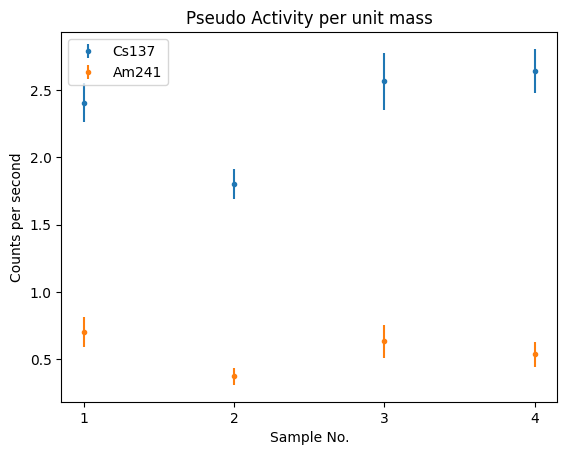

In [85]:
for nuc in ['Cs137','Am241']:
    plt.errorbar(np.arange(1,5,1),nuclide(nuc).pseudo_A
            ,yerr = nuclide(nuc).pseudo_A_err ,fmt='.',label = nuc)
    nuclide('Cs137').pseudo_A
    plt.ylabel('Counts per second')
    plt.xlabel('Sample No.')
    plt.title('Pseudo Activity per unit mass')
    plt.xticks(range(1,5))
    plt.legend()